## 001_simple_v1

This run uses a very simple model to get a rough idea for how difficult the problem is.

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../../')
# keras expects data to be encoded in a particular way, to_categorical does this encoding for us (one-hot encoding)
from keras.utils.np_utils import to_categorical
import libs.importing as importing
import pandas as pd
import os
import libs.render as render
import libs.cnn_models as cnn_models
import libs.analysis as analysis
import libs.normalization as normalization
from importlib import reload
import libs.data_prep as data_prep
import numpy as np

from pylab import rcParams
rcParams['figure.figsize'] = (10,8)

In [3]:
# LOAD PATCH DATA REFERENCES

# directory setup
data_source = '../4b7ab9e9'
train_dir = os.path.join(data_source, 'train')
test_dir = os.path.join(data_source, 'test')
val_dir = os.path.join(data_source, 'val')

# get references to the data we want
train_patches_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'))
train_data_reader = importing.PatchDataReader(os.path.join(train_dir, 'patches'), train_patches_df)

test_patches_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'))
test_data_reader = importing.PatchDataReader(os.path.join(test_dir, 'patches'), test_patches_df)

val_patches_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'))
val_data_reader = importing.PatchDataReader(os.path.join(val_dir, 'patches'), val_patches_df)

In [4]:
## READ PATCH DATA

# load train, test, and validation data
x_train, y_train = train_data_reader.read_data()
x_test, y_test = test_data_reader.read_data()
x_val, y_val = val_data_reader.read_data()

# LOG RESULTS
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_data_reader)
data_prep.log_patch_data_reader(test_dir, test_data_reader)
data_prep.log_patch_data_reader(val_dir, val_data_reader)

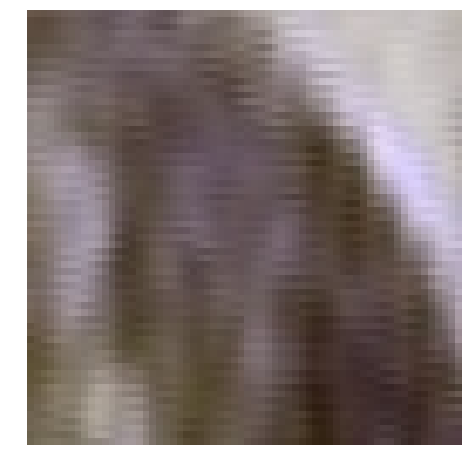

3


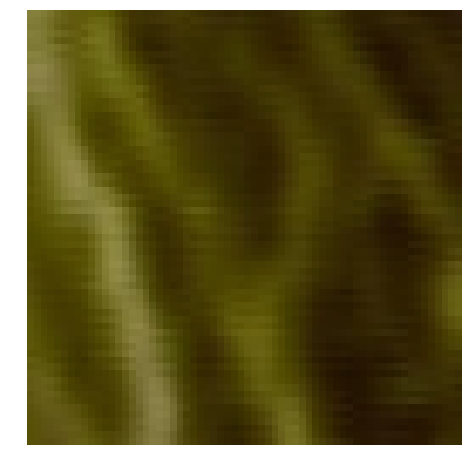

1


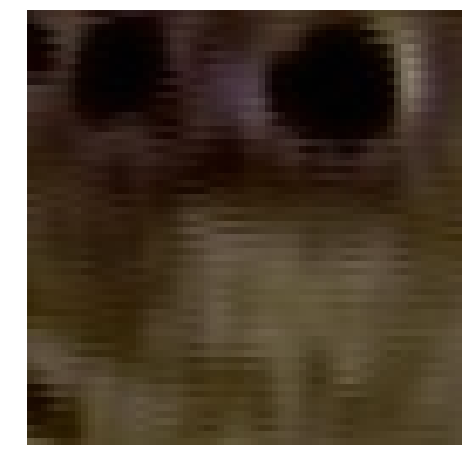

2


In [8]:
# INSPECT : look at class 1 = benign and 2 = papilloma, 3 = dysplasia+carcinoma

render.plot_image(x_train[0])
print(y_train[0])

render.plot_image(x_train[2])
print(y_train[2])

render.plot_image(x_train[8])
print(y_train[8])


In [9]:
## CONVERT CLASSES TO KERAS FORMAT
# keras expects classes to be number from 0-N, we are using 1-N numbering so we need to convert.
# then we also have to change the classes to one-hot encoding

y_train_oh = to_categorical(y_train - 1)
y_test_oh  = to_categorical(y_test - 1)
y_val_oh   = to_categorical(y_val - 1)

In [10]:
# NORMALIZATION

m, std = normalization.dataset_mean_and_std(x_train)

x_train = (x_train - m) / std
x_test  = (x_test - m) / std
x_val   = (x_val - m) / std

In [11]:
## MODEL : load from file, show summary, and compile
reload(cnn_models)

model = cnn_models.model_simple_v1_3class()
display(model.summary())

# parameters:
learning_rate = 1e-3

model.compile(optimizer = cnn_models.optimizer(), loss = "categorical_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 64)        0         
__________

None

In [12]:
data_prep.check_for_nans(x_train)
data_prep.check_for_nans(x_test)
data_prep.check_for_nans(x_val)

print(y_train[:100], y_test[:100], y_val[:100])

[3 3 1 3 3 3 1 2 2 3 3 3 3 1 3 3 3 3 3 3 1 3 3 3 3 1 3 3 3 3 1 3 3 2 3 3 3
 3 1 3 2 1 3 1 3 3 1 2 1 3 3 2 3 3 1 3 2 3 3 3 3 3 3 3 3 2 3 3 3 3 2 3 3 2
 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 2 1 2 3 3 2 3 3 3 3 3] [1 3 2 1 2 3 1 3 1 3 3 3 3 3 3 3 3 1 1 3 1 2 3 3 1 3 3 3 1 3 3 1 3 1 3 1 3
 3 1 1 2 3 3 1 3 3 3 3 1 1 3 3 3 1 1 3 1 3 1 1 3 1 1 2 3 1 1 3 3 3 2 1 1 2
 3 3 3 3 3 1 3 1 1 3 3 3 3 1 3 1 1 1 1 3 3 3 3 1 1 3] [1 2 1 1 1 3 3 2 1 1 1 2 2 3 3 1 3 2 1 1 1 3 3 3 1 3 1 1 2 2 2 1 1 3 1 1 3
 3 2 3 2 1 2 1 2 2 2 2 3 3 3 2 3 1 2 2 2 1 3 3 1 2 1 1 3 3 2 1 1 3 1 1 1 2
 2 3 1 2 3 3 3 3 3 3 3 2 1 2 2 3 1 2 3 1 1 3 2 1 1 1]


In [13]:
## RUN!!!

# parameters
batch_size = 16
epochs = 15

history = model.fit(x_train,y_train_oh, batch_size=batch_size,
                              epochs = epochs,
                              validation_data = (x_test,y_test_oh), shuffle=True,
                              verbose = 1, callbacks=[cnn_models.annealer()])

Train on 3415 samples, validate on 301 samples
Epoch 1/15
3415/3415 [==============================] - 40s 12ms/step - loss: 0.7907 - acc: 0.7678 - val_loss: 0.6222 - val_acc: 0.7973
Epoch 2/15
3415/3415 [==============================] - 5s 1ms/step - loss: 0.5697 - acc: 0.8023 - val_loss: 0.9784 - val_acc: 0.6512
Epoch 3/15
3415/3415 [==============================] - 5s 1ms/step - loss: 0.5153 - acc: 0.8129 - val_loss: 1.0666 - val_acc: 0.6977
Epoch 4/15
3415/3415 [==============================] - 5s 1ms/step - loss: 0.4516 - acc: 0.8322 - val_loss: 0.9999 - val_acc: 0.6545
Epoch 5/15
3415/3415 [==============================] - 5s 1ms/step - loss: 0.4514 - acc: 0.8448 - val_loss: 0.5720 - val_acc: 0.7608

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/15
3415/3415 [==============================] - 5s 1ms/step - loss: 0.2761 - acc: 0.8890 - val_loss: 1.2936 - val_acc: 0.8106
Epoch 7/15
3415/3415 [==============================] - 5s 1ms/ste

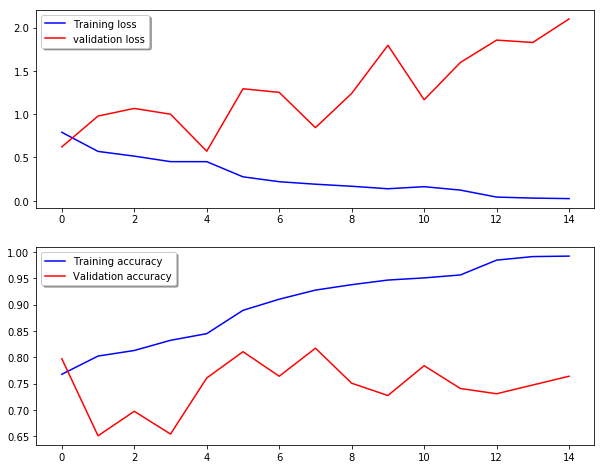

Precision (specificity): 78.048%
Recall (sensitivity): 74.625%
Accuracy: 77.491%
F1: 72.833%


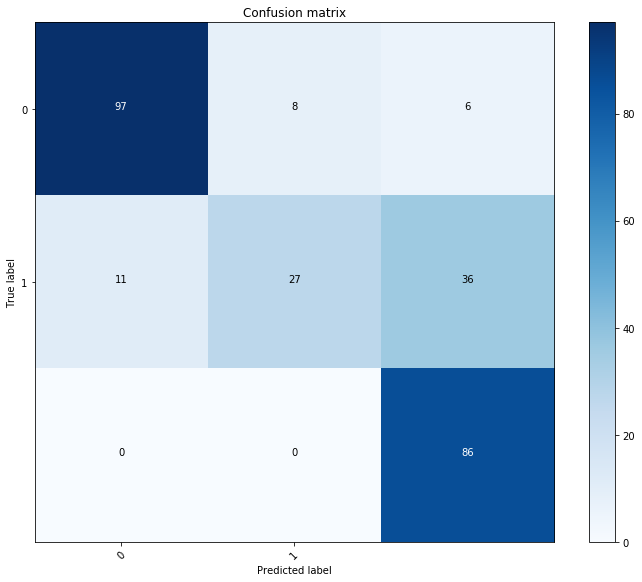

In [14]:
render.plot_training_and_validation_curves(history)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [15]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(test_data_reader, model, test_dir, norm_data=(m, std))
analysis.contour_statistics(test_data_reader, model, test_dir, norm_data=(m, std))

hgv-2cdb69f6 [1.3428972e-02 3.8525173e-05 9.8653245e-01] 1
mdi-461bdebc [8.4239179e-01 1.3305506e-06 1.5760684e-01] 0
mdi-5e3d3832 [0.6807784  0.06627877 0.2529429 ] 0
mdi-461bdebc [0.15242873 0.06525407 0.78231704] 2
hgv-2cdb69f6 [3.5542827e-10 1.5893631e-01 8.4106368e-01] 1
mdi-9ce9698b [1.7011148e-04 7.4384841e-09 9.9982983e-01] 2


In [16]:
model.save('model_001_simple.h5')